<a href="https://colab.research.google.com/github/mjavadpur/TSClassification/blob/main/TSCWithCNN_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing needed libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

inputPath = '/content/drive/MyDrive/Mohammad_Javadpur_TrafficSignsPreprocessed/Mohammad_Javadpur_TrafficSignsPreprocessed/Dataset'

import os
for dirname, _, filenames in os.walk(inputPath):#'../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(os.listdir(inputPath))#'../input'))

# Any results we write to the current directory are saved as output


/content/drive/MyDrive/Mohammad_Javadpur_TrafficSignsPreprocessed/Mohammad_Javadpur_TrafficSignsPreprocessed/Dataset/data0.pickle
/content/drive/MyDrive/Mohammad_Javadpur_TrafficSignsPreprocessed/Mohammad_Javadpur_TrafficSignsPreprocessed/Dataset/data1.pickle
/content/drive/MyDrive/Mohammad_Javadpur_TrafficSignsPreprocessed/Mohammad_Javadpur_TrafficSignsPreprocessed/Dataset/data2.pickle
/content/drive/MyDrive/Mohammad_Javadpur_TrafficSignsPreprocessed/Mohammad_Javadpur_TrafficSignsPreprocessed/Dataset/data3.pickle
/content/drive/MyDrive/Mohammad_Javadpur_TrafficSignsPreprocessed/Mohammad_Javadpur_TrafficSignsPreprocessed/Dataset/data4.pickle
/content/drive/MyDrive/Mohammad_Javadpur_TrafficSignsPreprocessed/Mohammad_Javadpur_TrafficSignsPreprocessed/Dataset/data5.pickle
/content/drive/MyDrive/Mohammad_Javadpur_TrafficSignsPreprocessed/Mohammad_Javadpur_TrafficSignsPreprocessed/Dataset/data6.pickle
/content/drive/MyDrive/Mohammad_Javadpur_TrafficSignsPreprocessed/Mohammad_Javadpur_Traffi

Loading dataset data2.pickle with RGB examples

In [ ]:
# Opening file for reading in binary mode
with open(inputPath+'/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

# x_train: (86989, 32, 32, 3)
# y_train: (86989, 43)
# x_test: (12630, 32, 32, 3)
# y_test: (12630,)
# x_validation: (4410, 32, 32, 3)
# y_validation: (4410, 43)
# labels: 43


y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


Showing some examples

(81, 32, 32, 3)


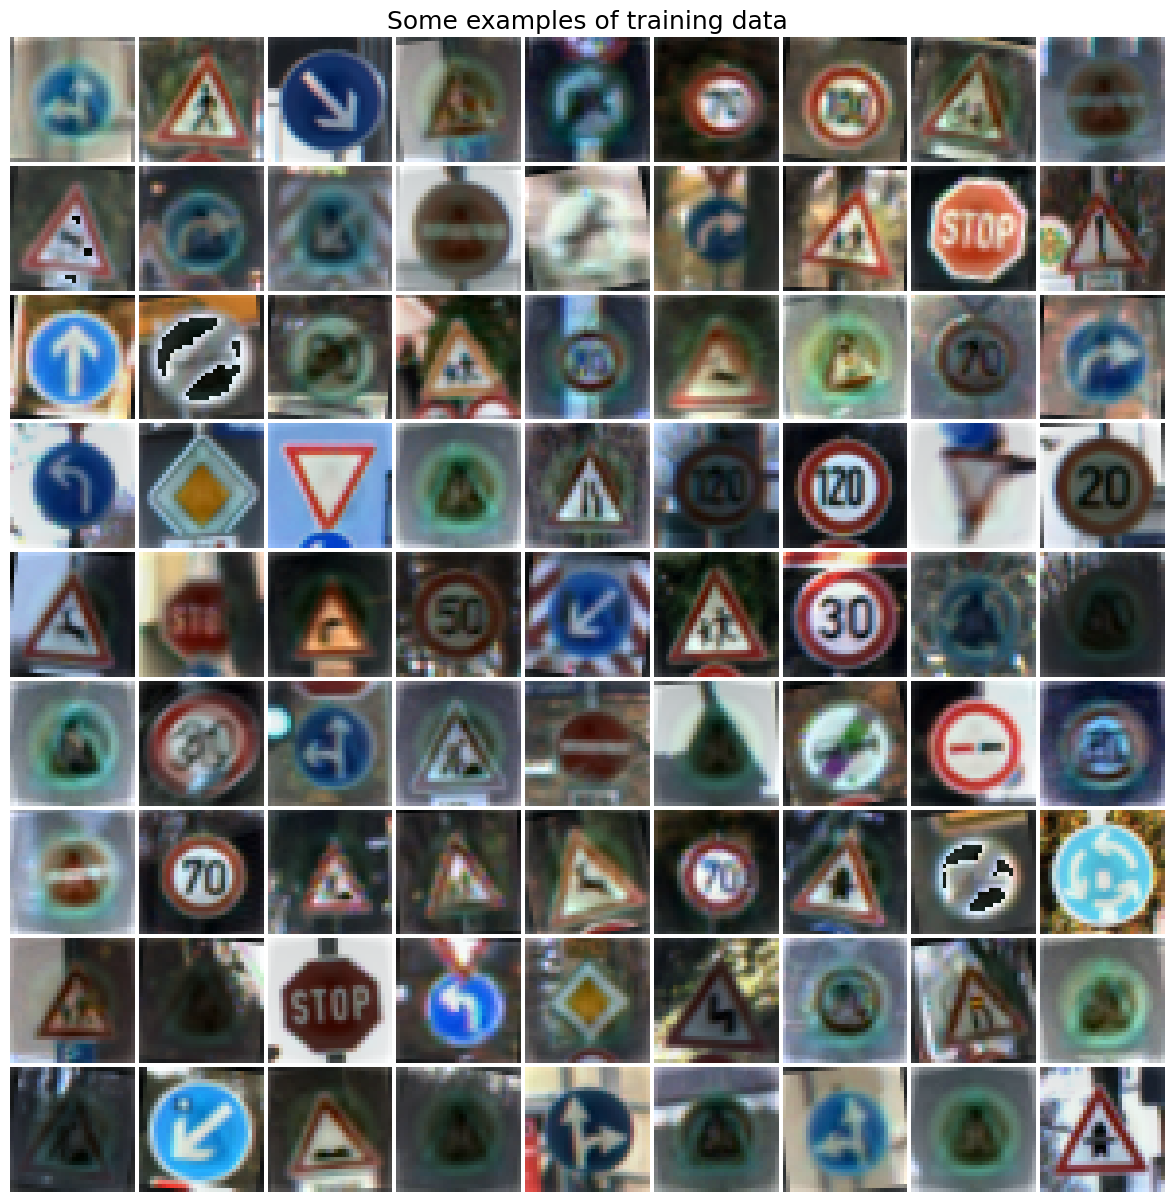

In [ ]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()

Building model of CNN with Keras

Trying one model with filters of size 3x3

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Overfitting the 3x3 model with small amount of data

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 15

h = model.fit(data['x_train'][:10], data['y_train'][:10],
              batch_size=5, epochs = epochs,
              validation_data = (data['x_validation'], data['y_validation']),
              callbacks=[annealer], verbose=1)

Epoch 1/15
2/2 [==============================] - 9s 8s/step - loss: 3.7991 - accuracy: 0.0000e+00 - val_loss: 3.8421 - val_accuracy: 0.0159 - lr: 4.6329e-04
Epoch 2/15
2/2 [==============================] - 6s 6s/step - loss: 2.9808 - accuracy: 0.3000 - val_loss: 3.9769 - val_accuracy: 0.0268 - lr: 4.4013e-04
Epoch 3/15
2/2 [==============================] - 10s 10s/step - loss: 2.3810 - accuracy: 0.3000 - val_loss: 4.2854 - val_accuracy: 0.0302 - lr: 4.1812e-04
Epoch 4/15
2/2 [==============================] - 7s 7s/step - loss: 1.9207 - accuracy: 0.5000 - val_loss: 4.7807 - val_accuracy: 0.0349 - lr: 3.9721e-04
Epoch 5/15
2/2 [==============================] - 8s 8s/step - loss: 1.5824 - accuracy: 0.6000 - val_loss: 5.3708 - val_accuracy: 0.0356 - lr: 3.7735e-04
Epoch 6/15
2/2 [==============================] - 8s 7s/step - loss: 1.3778 - accuracy: 0.7000 - val_loss: 5.9423 - val_accuracy: 0.0365 - lr: 3.5849e-04
Epoch 7/15
2/2 [==============================] - 10s 10s/step - loss:

In [ ]:
h.history

In [ ]:
print('Epochs={0:d}, training accuracy={1:.2f}, validation accuracy={2:.2f}'.\
      format(epochs, max(h.history['accuracy']), max(h.history['val_accuracy'])))

Epochs=15, training accuracy=1.00, validation accuracy=0.04


Plotting history results for overfitting small data

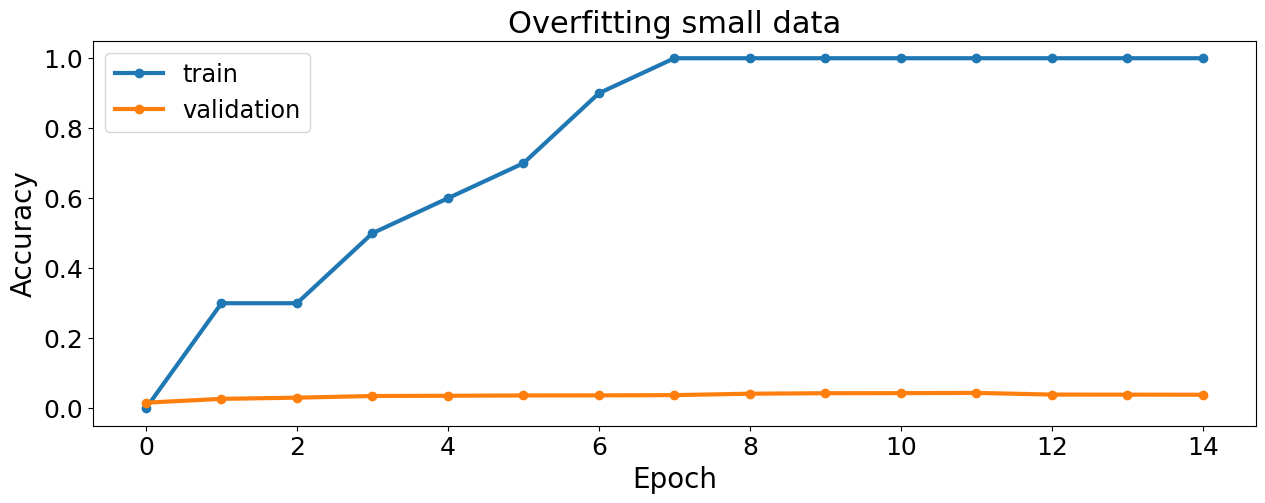

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure()
plt.plot(h.history['accuracy'], '-o', linewidth=3.0)
plt.plot(h.history['val_accuracy'], '-o', linewidth=3.0)
plt.title('Overfitting small data', fontsize=22)
plt.legend(['train', 'validation'], loc='upper left', fontsize='xx-large')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('overfitting_small_data.png')
plt.close()


# **Building set of models of CNN with Keras**

### **Trying different models with different dimensions of filters**

In [ ]:
filters = [3, 5, 9, 13, 15, 19, 23, 25, 31]
model = [0] * len(filters)

for i in range(len(model)):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size=filters[i], padding='same', activation='relu', input_shape=(32, 32, 3)))
    model[i].add(MaxPool2D(pool_size=2))
    model[i].add(Flatten())
    model[i].add(Dense(500, activation='relu'))
    model[i].add(Dense(43, activation='softmax'))
    model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Training set of models of CNN with Keras

And with different dimensions of filters

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 5

h = [0] * len(model)

for i in range(len(h)):
    print(i)
    h[i] = model[i].fit(data['x_train'], data['y_train'],
                        batch_size=5, epochs = epochs,
                        validation_data = (data['x_validation'], data['y_validation']),
                        callbacks=[annealer], verbose=0)
    
    print('Model with filters {0:d}x{0:d}, epochs={1:d}, training accuracy={2:.5f}, validation accuracy={3:.5f}'.\
      format(filters[i], epochs, max(h[i].history['accuracy']), max(h[i].history['val_accuracy'])))


0
Model with filters 3x3, epochs=5, training accuracy=0.99022, validation accuracy=0.88050
1
Model with filters 5x5, epochs=5, training accuracy=0.98679, validation accuracy=0.86463
2
Model with filters 9x9, epochs=5, training accuracy=0.98116, validation accuracy=0.87052
3
Model with filters 13x13, epochs=5, training accuracy=0.97348, validation accuracy=0.82834
4
Model with filters 15x15, epochs=5, training accuracy=0.97254, validation accuracy=0.83379
5


In [1]:
print('Model with filters {0:d}x{0:d}, epochs={1:d}, training accuracy={2:.5f}, validation accuracy={3:.5f}'.\
      format(filters[i], epochs, max(h[i].history['accuracy']), max(h[i].history['val_accuracy'])))

NameError: ignored

Plotting comparison results for accuracy

[<keras.callbacks.History at 0x7f93636b2da0>, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['font.family'] = 'Times New Roman'

# Plotting history of training accuracy
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(h[8].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[7].history['accuracy'], '-s', linewidth=3.0)
plt.plot(h[6].history['accuracy'], '-D', linewidth=3.0)
plt.plot(h[5].history['accuracy'], '-D', linewidth=3.0)
plt.plot(h[4].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[3].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[2].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[1].history['accuracy'], '-o', linewidth=3.0)
plt.plot(h[0].history['accuracy'], '-o', linewidth=3.0)
plt.legend(['filter 31', 'filter 25', 'filter 23', 'filter 19', 'filter 15', 'filter 13', 'filter 9', 'filter 5', 'filter 3'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=20, fontname='Times New Roman')
plt.ylabel('Training Accuracy', fontsize=20, fontname='Times New Roman')
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.85, 1.0)
plt.xlim(0.5, 5.3) 
plt.title('Accuracy for different sizes of filters', fontsize=22)
plt.tick_params(labelsize=18)

plt.subplot(2, 1, 2)
# plt.gca().set_title('Validation accuracy')
plt.plot(h[8].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[7].history['val_accuracy'], '-s', linewidth=3.0)
plt.plot(h[6].history['val_accuracy'], '-D', linewidth=3.0)
plt.plot(h[5].history['val_accuracy'], '-D', linewidth=3.0)
plt.plot(h[4].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[3].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[2].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[1].history['val_accuracy'], '-o', linewidth=3.0)
plt.plot(h[0].history['val_accuracy'], '-o', linewidth=3.0)
plt.legend(['filter 31', 'filter 25', 'filter 23', 'filter 19', 'filter 15', 'filter 13', 'filter 9', 'filter 5', 'filter 3'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=20, fontname='Times New Roman')
plt.ylabel('Validation Accuracy', fontsize=20, fontname='Times New Roman')
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.75, 0.9)
plt.xlim(0.5, 5.3)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('models_accuracy.png')
plt.close()


# Showing values of accuracy for different filters
for i in range(len(h)):
    print('data2 filter {0:d} training accuracy = {1:.5f}'.\
          format(filters[i], np.max(h[i].history['accuracy'])))

print()

for i in range(len(h)):
    print('data2 filter {0:d} validation accuracy = {1:.5f}'.\
          format(filters[i], np.max(h[i].history['val_accuracy'])))


NameError: ignored

Calculating accuracy with testing dataset

In [ ]:
for i in range(len(model)):
    temp = model[i].predict(data['x_test'])
    temp = np.argmax(temp, axis=1)

    # We compare predicted class with correct class for all input images
    # And calculating mean value among all values of following numpy array
    # By saying 'testing_accuracy == data['y_test']' we create numpy array with True and False values
    # 'np.mean' function will return average of the array elements
    # The average is taken over the flattened array by default
    temp = np.mean(temp == data['y_test'])
    
    print('data2 filter {0:d} testing accuracy = {1:.5f}'.format(filters[i], temp))

Time for classification

In [ ]:
# Getting scores from forward pass of one input image
# Scores are given for each image with 43 numbers of predictions for each class
# Measuring at the same time execution time

for i in range(len(model)):
    start = timer()
    temp = model[i].predict(data['x_test'][:1, :, :, :])
    end = timer()
    
    print('data2 filter {0:d} classification time = {1:.5f}'.format(filters[i], end - start))

Visualizing filters of convolutional layer

In [ ]:
for i in range(len(model)):
    w = model[i].get_weights()
    print(w[0].shape)
    # print(model[i].get_config())
    # l = model[i].layers
    # print(l[0].get_weights()[0].shape)

    # Visualizing filters
    temp = w[0].transpose(3, 0, 1, 2)
    print(temp.shape)  # (81, 32, 32, 3)

    # Plotting
    fig = plt.figure()
    grid = convert_to_grid(temp)
    plt.imshow(grid.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.gcf().set_size_inches(10, 10)
    name = 'Trained filters ' + str(filters[i]) + 'x' + str(filters[i])
    plt.title(name, fontsize=18)
    
    # Showing the plot
    plt.show()

    # Saving the plot
    name = 'filters-' + str(filters[i]) + 'x' + str(filters[i]) + '.png'
    fig.savefig(name)
    plt.close()

Predicting with one image from test dataset

In [ ]:
# Preparing image for predicting from test dataset
x_input = data['x_test'][100:101]
print(x_input.shape)
y_input = data['y_test'][100:101]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
plt.show()

# Getting scores from forward pass of input image
scores = model[0].predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text(inputPath+'/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])

Saving models

In [ ]:
for i in range(len(model)):
    name = 'model-' + str(filters[i]) + 'x' + str(filters[i]) + '.h5'
    model[i].save(name)

# # Saving model locally without committing
# from IPython.display import FileLink

# FileLink('model-3x3.h5')
